In [340]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
import matplotlib.ticker as ticker # per poder utilitzar FuncFormatter i aplicar format a la barra
import geopandas as gpd
import time
import folium
import os
import re
from mysql.connector import errorcode
from dotenv import load_dotenv # type: ignore # per dades accedir base dades
from datetime import datetime
from matplotlib.ticker import FuncFormatter # per poder utilitzar el separador de milersimport geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import Point
from geopy.exc import GeocoderTimedOut
from folium.plugins import MarkerCluster
from tabulate import tabulate # para formato de una tabla
from scipy import stats
from scipy.stats import skew
from scipy.stats import linregress
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer

#Librerías sk-learn para la imputación de review_nulas
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

#Para la validación cruzada
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

#Librería para gráficos interactivos en python
import plotly.graph_objects as go
import plotly.express as px

# Fuente Externa

In [341]:
df = pd.read_csv(r"C:\Users\diego\Desktop\Repositorio\ProjecteData\Equip_G\Data\2025_04_28_Sprint03.csv")

In [342]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9650 entries, 0 to 9649
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   apartment_id                 9650 non-null   int64  
 1   name                         9647 non-null   object 
 2   description                  9514 non-null   object 
 3   host_id                      9650 non-null   int64  
 4   neighbourhood_name           9650 non-null   object 
 5   neighbourhood_district       5860 non-null   object 
 6   room_type                    9650 non-null   object 
 7   accommodates                 9650 non-null   int64  
 8   bathrooms                    9584 non-null   float64
 9   bedrooms                     9583 non-null   float64
 10  beds                         9605 non-null   float64
 11  amenities_list               9650 non-null   object 
 12  price                        9650 non-null   float64
 13  minimum_nights    

In [343]:
df_Capacidad = df.groupby('city', as_index=False)['accommodates'].sum()
df_Capacidad['annual_capacity'] = df_Capacidad['accommodates'] * 365



In [344]:
df_Capacidad

,city,accommodates,annual_capacity
0,barcelona,8957,3269305
1,girona,8400,3066000
2,madrid,7072,2581280
3,malaga,2056,750440
4,mallorca,9514,3472610
5,menorca,1292,471580
6,sevilla,1939,707735
7,valencia,1946,710290


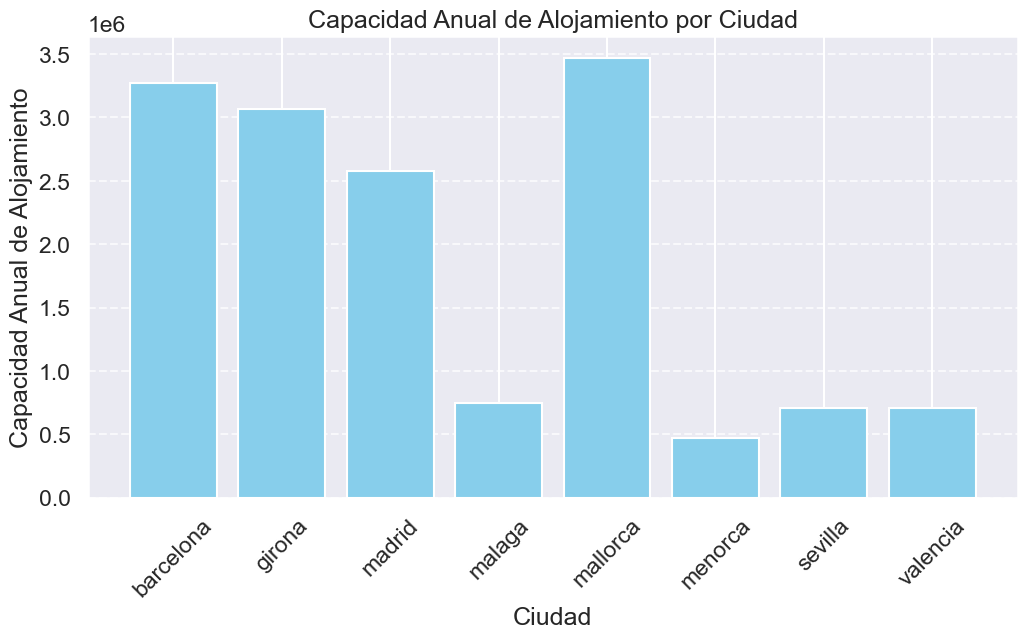

In [345]:
import matplotlib.pyplot as plt

# Crear el gráfico
plt.figure(figsize=(12, 6))
plt.bar(df_Capacidad['city'], df_Capacidad['annual_capacity'], color='skyblue')

# Personalizar el gráfico
plt.xlabel("Ciudad")
plt.ylabel("Capacidad Anual de Alojamiento")
plt.title("Capacidad Anual de Alojamiento por Ciudad")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()


In [346]:
df_CA_Pro = pd.read_csv(r"../Data\2074.csv", sep='\t', dtype={2: str}) #Viajeros y pernoctaciones por comunidades autónomas y provincias

In [347]:
df_CA_Pro.drop(columns=['Residencia: Nivel 1'], inplace=True)
df_CA_Pro.rename(columns={'Residencia: Nivel 2': 'Residencia'}, inplace=True)
df_CA_Pro['Periodo'] = pd.to_datetime(df_CA_Pro['Periodo'].str.replace('M', '-'), format='%Y-%m').dt.to_period('M')
df_CA_Pro['Total'] = df_CA_Pro['Total'].str.replace('.', '')  # Elimina los separadores de miles
df_CA_Pro['Total'] = df_CA_Pro['Total'].str.replace(',', '.')  # Convierte los decimales
df_CA_Pro['Total'] = pd.to_numeric(df_CA_Pro['Total'], errors='coerce')  # Convierte a float
#df_CA_Pro[df_CA_Pro['Total'].isna()]

In [348]:
df_CA_Pro['Provincias'].unique()

array([nan, '04 Almería', '11 Cádiz', '14 Córdoba', '18 Granada',
       '21 Huelva', '23 Jaén', '29 Málaga', '41 Sevilla', '22 Huesca',
       '44 Teruel', '50 Zaragoza', '33 Asturias', '07 Balears, Illes',
       '35 Palmas, Las', '38 Santa Cruz de Tenerife', '39 Cantabria',
       '05 Ávila', '09 Burgos', '24 León', '34 Palencia', '37 Salamanca',
       '40 Segovia', '42 Soria', '47 Valladolid', '49 Zamora',
       '02 Albacete', '13 Ciudad Real', '16 Cuenca', '19 Guadalajara',
       '45 Toledo', '08 Barcelona', '17 Girona', '25 Lleida',
       '43 Tarragona', '03 Alicante/Alacant', '12 Castellón/Castelló',
       '46 Valencia/València', '06 Badajoz', '10 Cáceres', '15 Coruña, A',
       '27 Lugo', '32 Ourense', '36 Pontevedra', '28 Madrid', '30 Murcia',
       '31 Navarra', '01 Araba/Álava', '48 Bizkaia', '20 Gipuzkoa',
       '26 Rioja, La'], dtype=object)

In [349]:
# Filtrar el periodo entre abril 2022 y abril 2024
df_filtered = df_CA_Pro[(df_CA_Pro['Periodo'] >= pd.Period('2022-04', freq='M')) & (df_CA_Pro['Periodo'] <= pd.Period('2024-04', freq='M'))]

# Mostrar las primeras filas para verificar
df_filtered


,Totales Territoriales,Comunidades y Ciudades Autónomas,Provincias,Viajeros y pernoctaciones,Residencia,Periodo,Total
11,Total Nacional,NaN,NaN,Viajero,NaN,2024-04,9394506.0
12,Total Nacional,NaN,NaN,Viajero,NaN,2024-03,8433226.0
13,Total Nacional,NaN,NaN,Viajero,NaN,2024-02,6512168.0
14,Total Nacional,NaN,NaN,Viajero,NaN,2024-01,5660859.0
15,Total Nacional,NaN,NaN,Viajero,NaN,2023-12,6586138.0
...,...,...,...,...,...,...,...
132016,Total Nacional,19 Melilla,NaN,Pernoctaciones,Residentes en el Extranjero,2022-08,3975.0
132017,Total Nacional,19 Melilla,NaN,Pernoctaciones,Residentes en el Extranjero,2022-07,3160.0
132018,Total Nacional,19 Melilla,NaN,Pernoctaciones,Residentes en el Extranjero,2022-06,985.0
132019,Total Nacional,19 Melilla,NaN,Pernoctaciones,Residentes en el Extranjero,2022-05,2066.0


In [350]:
# Lista de ciudades a filtrar
ciudades_filtrar = ['07 Balears, Illes', '46 Valencia/València', '41 Sevilla', 
                    '29 Málaga', '17 Girona', '28 Madrid', '08 Barcelona']

# Filtrar el DataFrame por las ciudades seleccionadas
df_filtrado = df_filtered[df_filtered['Provincias'].isin(ciudades_filtrar)]

df_filtrado = df_filtrado[df_filtrado["Viajeros y pernoctaciones"] == "Viajero"]

# Mostrar las primeras filas para verificar
df_filtrado


,Totales Territoriales,Comunidades y Ciudades Autónomas,Provincias,Viajeros y pernoctaciones,Residencia,Periodo,Total
15131,Total Nacional,01 Andalucía,29 Málaga,Viajero,NaN,2024-04,605359.0
15132,Total Nacional,01 Andalucía,29 Málaga,Viajero,NaN,2024-03,506900.0
15133,Total Nacional,01 Andalucía,29 Málaga,Viajero,NaN,2024-02,373782.0
15134,Total Nacional,01 Andalucía,29 Málaga,Viajero,NaN,2024-01,308291.0
15135,Total Nacional,01 Andalucía,29 Málaga,Viajero,NaN,2023-12,325375.0
...,...,...,...,...,...,...,...
108391,Total Nacional,"13 Madrid, Comunidad de",28 Madrid,Viajero,Residentes en el Extranjero,2022-08,406755.0
108392,Total Nacional,"13 Madrid, Comunidad de",28 Madrid,Viajero,Residentes en el Extranjero,2022-07,480915.0
108393,Total Nacional,"13 Madrid, Comunidad de",28 Madrid,Viajero,Residentes en el Extranjero,2022-06,461468.0
108394,Total Nacional,"13 Madrid, Comunidad de",28 Madrid,Viajero,Residentes en el Extranjero,2022-05,460034.0


In [351]:
# Agrupar por ciudad y sumar el total de personas
Pasado = df_filtrado.groupby('Provincias')['Total'].sum().reset_index()

# Dividir entre 2 para obtener el promedio anual
Pasado['Promedio_Anual'] = Pasado['Total'] / 2

# Mostrar las primeras filas para verificar
Pasado.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Provincias      7 non-null      object 
 1   Total           7 non-null      float64
 2   Promedio_Anual  7 non-null      float64
dtypes: float64(2), object(1)
memory usage: 300.0+ bytes


In [352]:
Pasado

,Provincias,Total,Promedio_Anual
0,"07 Balears, Illes",46794718.0,23397359.0
1,08 Barcelona,52244237.0,26122118.5
2,17 Girona,17243677.0,8621838.5
3,28 Madrid,51395412.0,25697706.0
4,29 Málaga,25803877.0,12901938.5
5,41 Sevilla,15438879.0,7719439.5
6,46 Valencia/València,15133536.0,7566768.0


In [353]:
equivalencias_ciudades = {
    "barcelona": "08 Barcelona",
    "girona": "17 Girona",
    "madrid": "28 Madrid",
    "malaga": "29 Málaga",
    "mallorca": "07 Balears, Illes",
    "menorca": "07 Balears, Illes",  # Sumamos Menorca a Baleares
    "sevilla": "41 Sevilla",
    "valencia": "46 Valencia/València"
}


In [354]:
df_Capacidad["Provincias"] = df_Capacidad["city"].map(equivalencias_ciudades)

# Agrupar los datos sumando los valores de Mallorca y Menorca bajo "07 Balears, Illes"
df_Capacidad = df_Capacidad.groupby("Provincias", as_index=False).sum()

print(df_Capacidad)


             Provincias             city  accommodates  annual_capacity
0     07 Balears, Illes  mallorcamenorca         10806          3944190
1          08 Barcelona        barcelona          8957          3269305
2             17 Girona           girona          8400          3066000
3             28 Madrid           madrid          7072          2581280
4             29 Málaga           malaga          2056           750440
5            41 Sevilla          sevilla          1939           707735
6  46 Valencia/València         valencia          1946           710290


In [355]:
df_Capacidad

,Provincias,city,accommodates,annual_capacity
0,"07 Balears, Illes",mallorcamenorca,10806,3944190
1,08 Barcelona,barcelona,8957,3269305
2,17 Girona,girona,8400,3066000
3,28 Madrid,madrid,7072,2581280
4,29 Málaga,malaga,2056,750440
5,41 Sevilla,sevilla,1939,707735
6,46 Valencia/València,valencia,1946,710290


In [356]:
Pasado


,Provincias,Total,Promedio_Anual
0,"07 Balears, Illes",46794718.0,23397359.0
1,08 Barcelona,52244237.0,26122118.5
2,17 Girona,17243677.0,8621838.5
3,28 Madrid,51395412.0,25697706.0
4,29 Málaga,25803877.0,12901938.5
5,41 Sevilla,15438879.0,7719439.5
6,46 Valencia/València,15133536.0,7566768.0


In [357]:
# Unir los DataFrames por la columna 'Provincias'
df_final = df_Capacidad.merge(Pasado[['Provincias', 'Promedio_Anual']], on='Provincias', how='left', suffixes=('_alojamiento', '_visitantes'))

# Mostrar el resultado
df_final


,Provincias,city,accommodates,annual_capacity,Promedio_Anual
0,"07 Balears, Illes",mallorcamenorca,10806,3944190,23397359.0
1,08 Barcelona,barcelona,8957,3269305,26122118.5
2,17 Girona,girona,8400,3066000,8621838.5
3,28 Madrid,madrid,7072,2581280,25697706.0
4,29 Málaga,malaga,2056,750440,12901938.5
5,41 Sevilla,sevilla,1939,707735,7719439.5
6,46 Valencia/València,valencia,1946,710290,7566768.0


In [358]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Provincias       7 non-null      object 
 1   city             7 non-null      object 
 2   accommodates     7 non-null      int64  
 3   annual_capacity  7 non-null      int64  
 4   Promedio_Anual   7 non-null      float64
dtypes: float64(1), int64(2), object(2)
memory usage: 412.0+ bytes


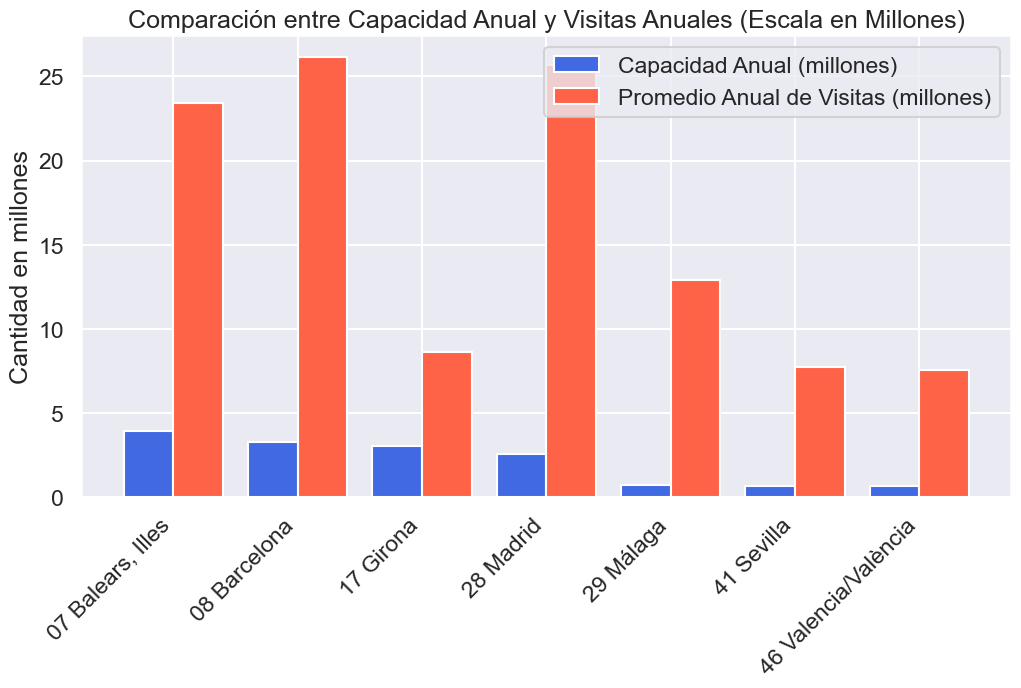

In [359]:
# Convertimos los valores a millones
df_final["annual_capacity"] /= 1_000_000
df_final["Promedio_Anual"] /= 1_000_000

# Configurar las posiciones de las barras
x = np.arange(len(df_final["Provincias"]))  

# Tamaño del gráfico
fig, ax = plt.subplots(figsize=(12, 6))

# Crear las barras en escala de millones
ax.bar(x - 0.2, df_final["annual_capacity"], width=0.4, label="Capacidad Anual (millones)", color="royalblue")
ax.bar(x + 0.2, df_final["Promedio_Anual"], width=0.4, label="Promedio Anual de Visitas (millones)", color="tomato")

# Configurar etiquetas
ax.set_xticks(x)
ax.set_xticklabels(df_final["Provincias"], rotation=45, ha="right")
ax.set_ylabel("Cantidad en millones")
ax.set_title("Comparación entre Capacidad Anual y Visitas Anuales (Escala en Millones)")
ax.legend()

# Mostrar el gráfico
plt.show()